In [1]:
# Check that we have access to gpu

!nvidia-smi

Fri May 12 06:57:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Set up COLAB with KAGGLE api to download the dataset

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
 !pip install -q kaggle

In [5]:
!kaggle competitions download -c dogs-vs-cats

 97% 788M/812M [00:04<00:00, 227MB/s]
100% 812M/812M [00:04<00:00, 178MB/s]


In [6]:
!mkdir dogs-vs-cats
!unzip dogs-vs-cats.zip -d dogs-vs-cats

Archive:  dogs-vs-cats.zip
  inflating: dogs-vs-cats/sampleSubmission.csv  
  inflating: dogs-vs-cats/test1.zip  
  inflating: dogs-vs-cats/train.zip  


# CutMix Augmentation

In [7]:
# import
import os
import random

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import IPython.display

In [8]:
# set up paths
BASE_DIR = os.getcwd()
DATA_DIR = "/content/dogs-vs-cats"

In [9]:
# extract dataset from compressed files
import zipfile

with zipfile.ZipFile(f'{DATA_DIR}/train.zip', 'r') as zip_ref:
    zip_ref.extractall(BASE_DIR)

In [10]:
with zipfile.ZipFile(f'{DATA_DIR}/test1.zip', 'r') as zip_ref:
    zip_ref.extractall(BASE_DIR)

In [11]:
# move the all cat images to DIR named cat and dog images to DIR named dog
!mkdir ./train/cat
!mkdir ./train/dog

In [12]:
!mv ./train/cat*.jpg ./train/cat

In [13]:
!mv ./train/dog*.jpg ./train/dog

In [17]:
!tree -d

.
├── dogs-vs-cats
├── sample_data
├── test1
└── train
    ├── cat
    └── dog

6 directories


## Preprocess trainning data for augmentation

In [18]:
# Define hyperparameters
AUTO = tf.data.AUTOTUNE
class_names = ['cat', 'dog']
batch_size = 32
img_height = 227
img_width = 227

In [19]:
train_ds, validation_ds  = keras.utils.image_dataset_from_directory(
    './train',
    labels='inferred',
    label_mode='binary',
    class_names=class_names,
    validation_split=0.2,
    subset="both",
    shuffle=True,  
    seed=42,
    image_size=(img_height, img_width),
    batch_size=2)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


In [20]:
# Configure the dataset for performance
train_ds = train_ds.prefetch(buffer_size=AUTO)
validation_ds = validation_ds.prefetch(buffer_size=AUTO)

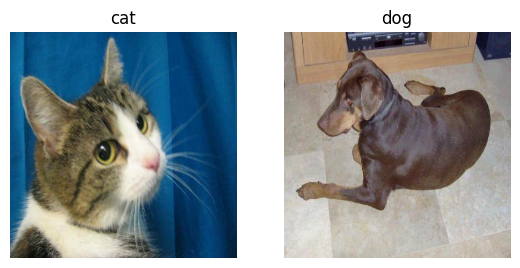

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(2):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Apply CutMix augmentation

In [22]:
# function to return the Beta distribution
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

In [23]:
# function to get the bounding box
@tf.function
def get_box(lambda_value):
    cut_rate = tf.math.sqrt(1.0 - lambda_value)

    cut_w = img_width * cut_rate  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = img_height * cut_rate  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=img_width, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=img_height, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, img_width)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, img_height)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, img_width)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, img_height)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w

In [24]:
# CutMix augmentation function
@tf.function
def cutmix(images, labels):
    image1 = images[0]
    image2 = images[1]
    label1 = labels[0]
    label2 = labels[1]

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, img_height, img_width
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, img_height, img_width
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (img_height * img_width)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

In [25]:
# create dataset for augmentation
augmentation_train_ds = train_ds.map(cutmix, num_parallel_calls=AUTO).prefetch(AUTO)

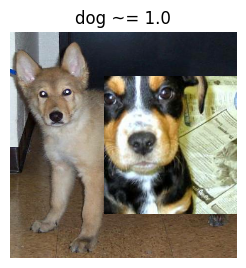

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in augmentation_train_ds.take(1):
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(f"{class_names[int(labels)]} ~= {float(labels)}")
    plt.axis("off")

In [27]:
# make directory name train_augmentation to save augmentated data
!mkdir ./train_augmentation

In [28]:
!tree -d

.
├── dogs-vs-cats
├── sample_data
├── test1
├── train
│   ├── cat
│   └── dog
└── train_augmentation

7 directories


In [29]:
# save augmentated dataset as images the name of the image is the label
for image, label in augmentation_train_ds:
    img = Image.fromarray(image.numpy().astype('uint8'))
    if 0.5 <= label[0].numpy() <= 1.0:
        img.save(f"./train_augmentation/dog.{label[0].numpy()}_{random.random():.7}.jpg")
    elif 0.0 <= label[0].numpy() < 0.5:
        img.save(f"./train_augmentation/cat.{label[0].numpy()}_{random.random():.7}.jpg")

## Set up test dataset

In [30]:
# load the test labels using pandas
labels_df = pd.read_csv(f"{DATA_DIR}/sampleSubmission.csv")

In [31]:
labels_df.head(10)

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [32]:
len(labels_df) == len(os.listdir("./test1"))

True

In [33]:
labels_df['label'].value_counts()

0    12500
Name: label, dtype: int64

In [34]:
# rename files to represnt their classes
for img_name in labels_df['id']:
    if (labels_df[labels_df['id'] == 9].label == 0).item() :
        os.rename(f"./test1/{img_name}.jpg", f"./test1/cat.{img_name}.jpg")
    else:
        os.rename(f"./test1/{img_name}.jpg", f"./test1/dog.{img_name}.jpg")

## Download the pre trainied model YOLOv8

In [35]:
# install ultralytics package using cli

!pip install ultralytics

IPython.display.clear_output()

import ultralytics

ultralytics.checks()

Ultralytics YOLOv8.0.98 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.0/78.2 GB disk)


In [36]:
from ultralytics import YOLO

## Set up dataset structure for training

In [ ]:
# The final structre, We want to achive
!tree -d

.
├── dataset_with_augmentation
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── val
│       ├── cat
│       └── dog
├── dataset_without_augmentation
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── val
│       ├── cat
│       └── dog
└── dogs-vs-cats

15 directories


In [37]:
# dataset_without_augmentation
!mkdir dataset_without_augmentation

In [38]:
!mv train/ dataset_without_augmentation

In [39]:
!mv test1/ val/

In [40]:
!mv val/ dataset_without_augmentation

In [41]:
!mkdir dataset_without_augmentation/val/cat
!mkdir dataset_without_augmentation/val/dog

In [ ]:
!mv dataset_without_augmentation/val/cat*.jpg dataset_without_augmentation/val/cat
!mv dataset_without_augmentation/val/dog*.jpg dataset_without_augmentation/val/dog

In [43]:
!tree -d

.
├── dataset_without_augmentation
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── val
│       ├── cat
│       └── dog
├── dogs-vs-cats
└── train_augmentation

9 directories


In [44]:
# dataset_with_augmentation
!mkdir dataset_with_augmentation

In [45]:
!mv train_augmentation/ train/
!mv train/ dataset_with_augmentation/

In [46]:
!mkdir dataset_with_augmentation/train/cat
!mkdir dataset_with_augmentation/train/dog

In [47]:
!mv dataset_with_augmentation/train/cat*.jpg dataset_with_augmentation/train/cat
!mv dataset_with_augmentation/train/dog*.jpg dataset_with_augmentation/train/dog

In [48]:
!mkdir dataset_with_augmentation/val
!cp -r dataset_without_augmentation/val/cat dataset_with_augmentation/val
!cp -r dataset_without_augmentation/val/dog dataset_with_augmentation/val

In [49]:
# copy the without augmentation training images to increase the number of samples
!cp -r dataset_without_augmentation/train/cat/cat*.jpg dataset_with_augmentation/train/cat
!cp -r dataset_without_augmentation/train/dog/dog*.jpg dataset_with_augmentation/train/dog

In [50]:
len(os.listdir("dataset_with_augmentation/train/dog")) + len(os.listdir("dataset_with_augmentation/train/cat"))

35000

In [51]:
# The final structure
!tree -d

.
├── dataset_with_augmentation
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── val
│       ├── cat
│       └── dog
├── dataset_without_augmentation
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── val
│       ├── cat
│       └── dog
└── dogs-vs-cats

15 directories


## Train model on normal dataset without augmentation

In [52]:
!mkdir datasets
!cp -r dataset_without_augmentation datasets

In [53]:
!cp -r /content/datasets/dataset_without_augmentation/train/dog/dog*.jpg /content/datasets/dataset_without_augmentation/val/dog/

In [54]:
# Load a model
model_1 = YOLO('yolov8n-cls.yaml').load('yolov8n-cls.pt')  # build from YAML and transfer weights

# Train the model
model_1.train(data="dataset_without_augmentation/", epochs=10, device=0, workers=12, save=True, plots=True)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [55]:
# helper function to show results
def show_results(src_dir: str) -> None:
    for f in os.listdir(src_dir):
      if f.endswith(".png") or f.endswith(".jpg"):
        # Open the image
        image = Image.open(f"{src_dir}/{f}")
    
        # Set the width to 800 and calculate the height
        width = 800
        height = 800
    
        # Resize the image
        image = image.resize((width, height), Image.ANTIALIAS)
    
        # Display the image
        IPython.display.display(image)

In [ ]:
show_results(f"{BASE_DIR}/runs/classify/train")

In [57]:
# Validate the model
model_1 = YOLO(f"{BASE_DIR}/runs/classify/train/weights/best.pt")
model_1.val()

Ultralytics YOLOv8.0.98 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1437442 parameters, 0 gradients, 3.3 GFLOPs
               classes   top1_acc   top5_acc: 100%|██████████| 1563/1563 [01:17<00:00, 20.25it/s]
                   all      0.703          1
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val


ultralytics.yolo.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f944a53b9a0>
fitness: 1.0
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7029199600219727, 'metrics/accuracy_top5': 1.0, 'fitness': 1.0}
speed: {'preprocess': 0.07543664932250976, 'inference': 0.5660964679718018, 'loss': 0.0013762760162353517, 'postprocess': 0.0021186542510986325}
top1: 0.7029199600219727
top5: 1.0

In [ ]:
show_results(f"{BASE_DIR}/runs/classify/val")

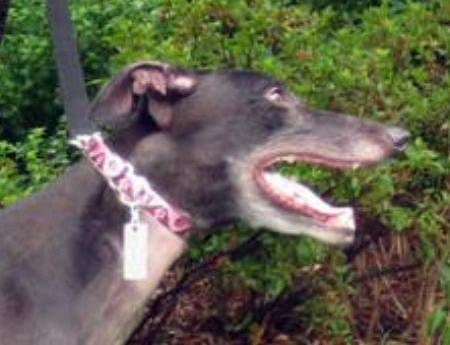

In [59]:
# Inference with Custom Model
index = list(set(os.listdir(f'{BASE_DIR}/dataset_without_augmentation/train/cat/'))) + list(set(os.listdir(f'{BASE_DIR}/dataset_without_augmentation/train/dog/')))
img_name = random.choice(index)
temp = ''
if img_name.startswith('cat'):
    temp = f'{BASE_DIR}/dataset_without_augmentation/train/cat/{img_name}'
else:
    temp = f'{BASE_DIR}/dataset_without_augmentation/train/dog/{img_name}'
IPython.display.Image(filename=f'{temp}',width=800)

In [60]:
model_1.predict(f'{temp}', save=True)


image 1/1 /content/dataset_without_augmentation/train/dog/dog.2671.jpg: 224x224 dog 0.88, cat 0.12, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
Results saved to runs/classify/predict


[ultralytics.yolo.engine.results.Results object with attributes:
 
 boxes: None
 keypoints: None
 keys: ['probs']
 masks: None
 names: {0: 'cat', 1: 'dog'}
 orig_img: array([[[ 49,  35,  41],
         [ 52,  38,  44],
         [ 46,  32,  36],
         ...,
         [ 31, 116,  88],
         [ 31, 113,  90],
         [ 33, 113,  90]],
 
        [[ 38,  24,  30],
         [ 42,  28,  34],
         [ 38,  24,  28],
         ...,
         [ 38, 122,  97],
         [ 30, 110,  87],
         [ 30, 109,  88]],
 
        [[ 37,  23,  29],
         [ 40,  26,  32],
         [ 37,  26,  29],
         ...,
         [ 42, 125, 103],
         [ 29, 108,  89],
         [ 31, 107,  89]],
 
        ...,
 
        [[119, 113, 130],
         [115, 109, 126],
         [112, 106, 123],
         ...,
         [ 43, 111,  80],
         [ 38, 102,  72],
         [ 38, 103,  71]],
 
        [[120, 114, 131],
         [116, 110, 127],
         [112, 106, 123],
         ...,
         [ 42, 109,  78],
         

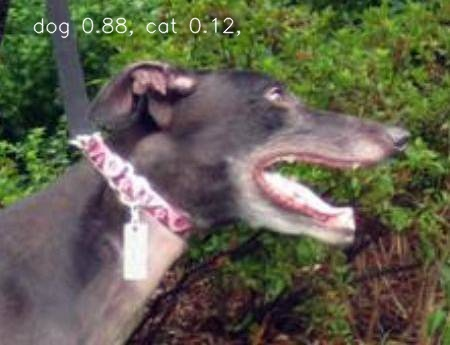

In [61]:
IPython.display.Image(filename=f'{BASE_DIR}/runs/classify/predict/{img_name}',width=800)

## Train model on CutMix augmentated dataset

In [62]:
!cp -r dataset_with_augmentation datasets

In [63]:
!cp -r /content/datasets/dataset_with_augmentation/train/dog/dog*.jpg /content/datasets/dataset_with_augmentation/val/dog/

In [64]:
# Load a model
model_2 = YOLO('yolov8n-cls.yaml').load('yolov8n-cls.pt')  # build from YAML and transfer weights

# Train the model
model_2.train(data="dataset_with_augmentation/", epochs=10, device=0, workers=12, save=True, plots=True)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [ ]:
show_results(f"{BASE_DIR}/runs/classify/train2")

In [66]:
# Validate the model
model_2 = YOLO(f"{BASE_DIR}/runs/classify/train2/weights/best.pt")
model_2.val()

Ultralytics YOLOv8.0.98 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1437442 parameters, 0 gradients, 3.3 GFLOPs
               classes   top1_acc   top5_acc: 100%|██████████| 1873/1873 [01:29<00:00, 21.01it/s]
                   all       0.74          1
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val2


ultralytics.yolo.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f93c1955690>
fitness: 1.0
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7402536869049072, 'metrics/accuracy_top5': 1.0, 'fitness': 1.0}
speed: {'preprocess': 0.08417410907821757, 'inference': 0.5753453169391056, 'loss': 0.002375829999691972, 'postprocess': 0.0011248247964041572}
top1: 0.7402536869049072
top5: 1.0

In [ ]:
show_results(f"{BASE_DIR}/runs/classify/val2")

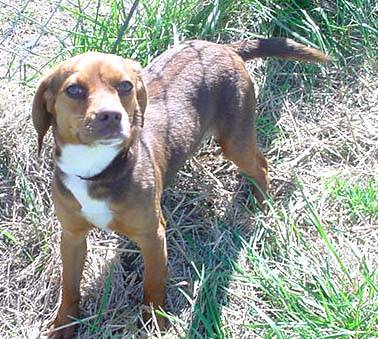

In [69]:
# Inference with Custom Model
index = list(set(os.listdir(f'{BASE_DIR}/dataset_with_augmentation/train/cat/'))) + list(set(os.listdir(f'{BASE_DIR}/dataset_with_augmentation/train/dog/')))
img_name = random.choice(index)
temp = ''
if img_name.startswith('cat'):
    temp = f'{BASE_DIR}/dataset_with_augmentation/train/cat/{img_name}'
else:
    temp = f'{BASE_DIR}/dataset_with_augmentation/train/dog/{img_name}'
IPython.display.Image(filename=f'{temp}',width=800)

In [70]:
model_1.predict(f'{temp}', save=True)


image 1/1 /content/dataset_with_augmentation/train/dog/dog.2125.jpg: 224x224 dog 1.00, cat 0.00, 10.1ms
Speed: 3.6ms preprocess, 10.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
Results saved to runs/classify/predict


[ultralytics.yolo.engine.results.Results object with attributes:
 
 boxes: None
 keypoints: None
 keys: ['probs']
 masks: None
 names: {0: 'cat', 1: 'dog'}
 orig_img: array([[[255, 253, 251],
         [255, 250, 248],
         [249, 237, 235],
         ...,
         [222, 224, 195],
         [174, 176, 147],
         [162, 164, 135]],
 
        [[172, 160, 158],
         [232, 220, 218],
         [255, 250, 248],
         ...,
         [184, 186, 157],
         [126, 128,  99],
         [103, 105,  76]],
 
        [[213, 204, 201],
         [159, 150, 147],
         [150, 141, 138],
         ...,
         [109, 111,  82],
         [166, 165, 139],
         [125, 124,  98]],
 
        ...,
 
        [[255, 252, 255],
         [240, 230, 236],
         [157, 150, 155],
         ...,
         [174, 225, 181],
         [ 93, 146, 102],
         [ 67, 121,  74]],
 
        [[254, 247, 252],
         [255, 250, 255],
         [200, 194, 199],
         ...,
         [183, 218, 191],
         

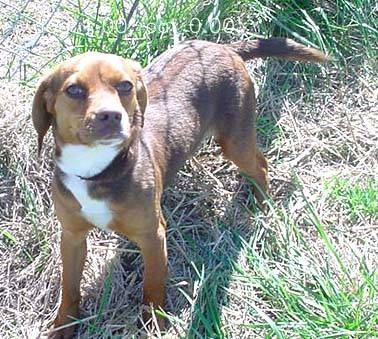

In [72]:
IPython.display.Image(filename=f'{BASE_DIR}/runs/classify/predict/{img_name}',width=800)

---

In [73]:
# compress the results for saving
import zipfile
with zipfile.ZipFile("runs.zip", 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(f"{BASE_DIR}/runs/"):
        for fil in files:
            # Construct the full file path
            file_path = os.path.join(root, fil)
            # Add the file to the zipfile
            zipf.write(file_path, os.path.relpath(file_path, f"{BASE_DIR}/runs/"))